<a href="https://colab.research.google.com/github/hmod7an/Mlproject/blob/main/finalml4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install shap -q


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.ensemble import (
    RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier,
    RandomForestRegressor, GradientBoostingRegressor
)

import shap

print("✅ Libraries imported")


✅ Libraries imported


In [ ]:
from google.colab import files
print("Upload your Excel dataset")
uploaded = files.upload()


Upload your Excel dataset


Saving cleaned_dataset (3).xlsx to cleaned_dataset (3).xlsx


In [ ]:
df = pd.read_excel(list(uploaded.keys())[0])
print("✅ Dataset loaded")
print(df.shape)
df.head()

✅ Dataset loaded
(435, 31)


,order_Quantity,customer_Name,customer_ID,order_Date,Expected_Delivery_date,delivery_Date,Actual_Delivery_Days,order_ID,order_Tailor,order_Type,...,size,length_cm,width_cm,sleeve_cm,fabric_meters,Price_Per_Unit,Fabric_Price_Per_Meter,Satisfaction,Dissatisfaction_Reason,Days_Difference
0,1,Al*,2240,2025-08-01,2025-08-08,2025-08-02,1.0,2723,001,tailoring,...,S,69.5,48.5,21.5,1.80,350.0,194.444444,1,NaN,1.0
1,5,Ab******,150,2025-08-01,2025-08-08,2025-08-18,17.0,2717,001,tailoring,...,L,73.0,55.5,23.0,1.90,450.0,236.842105,0,Delivery Delay (17 days),17.0
2,3,Ab*********,150,2025-08-01,2025-08-08,2025-08-04,3.0,2718,001,tailoring,...,S,70.5,48.5,21.5,1.80,250.0,138.888889,1,NaN,3.0
3,3,Ya***,150,2025-08-01,2025-08-08,2025-08-04,3.0,2719,001,tailoring,...,XL,73.5,55.5,22.5,1.95,300.0,153.846154,1,NaN,3.0
4,1,Bi***,2238,2025-08-01,2025-08-08,2025-08-11,10.0,2720,001,tailoring,...,XL,74.0,53.5,23.5,1.95,200.0,102.564103,0,Delivery Delay (10 days),10.0


In [ ]:
df.rename(columns={
    'order_Date': 'order_date',
    'Expected_Delivery_date': 'promised_date',
    'delivery_Date': 'delivery_date',
    'customer_ID': 'customer_id',
    'order_ID': 'order_id'
}, inplace=True)


In [ ]:
date_cols = ['order_date', 'promised_date', 'delivery_date']

for col in date_cols:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors='coerce')


In [ ]:
df['Days_Difference'] = (df['delivery_date'] - df['promised_date']).dt.days

if 'Satisfaction' not in df.columns:
    df['Satisfaction'] = (df['Days_Difference'] <= 7).astype(int)

df[['Days_Difference', 'Satisfaction']].head()


,Days_Difference,Satisfaction
0,-6.0,1
1,10.0,0
2,-4.0,1
3,-4.0,1
4,3.0,0


In [ ]:
data = df.copy()
label_encoders = {}

cat_cols = data.select_dtypes(include='object').columns
for col in cat_cols:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col].astype(str))
    label_encoders[col] = le

print("✅ Encoded columns:", len(cat_cols))


✅ Encoded columns: 9


In [ ]:
exclude_cols = [
    'Satisfaction', 'Days_Difference',
    'order_date', 'promised_date', 'delivery_date',
    'customer_id', 'order_id',
    'Dissatisfaction_Reason'
]

X = data.drop(columns=exclude_cols)
y_class = data['Satisfaction']
y_reg = data['Days_Difference']

X = X.fillna(X.median())


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y_class, test_size=0.2, random_state=42, stratify=y_class
)

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

print("✅ Classification data ready")


✅ Classification data ready


In [ ]:
results = {}

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(),
    "KNN": KNeighborsClassifier(),
    "SVM": SVC()
}

for name, model in models.items():
    model.fit(X_train_s, y_train)
    acc = accuracy_score(y_test, model.predict(X_test_s))
    results[name] = acc
    print(f"{name}: {acc:.4f}")


Logistic Regression: 0.6092
Decision Tree: 0.9195
KNN: 0.7011
SVM: 0.7241


In [ ]:
ensemble_models = {
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "AdaBoost": AdaBoostClassifier()
}

for name, model in ensemble_models.items():
    model.fit(X_train_s, y_train)
    acc = accuracy_score(y_test, model.predict(X_test_s))
    results[name] = acc
    print(f"{name}: {acc:.4f}")


Random Forest: 0.9195
Gradient Boosting: 0.9425
AdaBoost: 0.9195


In [ ]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 20]
}

grid = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

grid.fit(X_train_s, y_train)

best_rf = grid.best_estimator_
results['Random Forest (Tuned)'] = accuracy_score(
    y_test, best_rf.predict(X_test_s)
)

print("✅ Best RF:", grid.best_params_)


✅ Best RF: {'max_depth': None, 'n_estimators': 100}


In [ ]:
results_df = pd.DataFrame({
    'Model': results.keys(),
    'Accuracy': results.values()
}).sort_values('Accuracy', ascending=False)

results_df


,Model,Accuracy
5,Gradient Boosting,0.942529
1,Decision Tree,0.919540
4,Random Forest,0.919540
6,AdaBoost,0.919540
7,Random Forest (Tuned),0.908046
3,SVM,0.724138
2,KNN,0.701149
0,Logistic Regression,0.609195


from matplotlib import pyplot as plt
results_df['Accuracy'].plot(kind='hist', bins=20, title='Accuracy')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
results_df.groupby('Model').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
results_df['Accuracy'].plot(kind='line', figsize=(8, 4), title='Accuracy')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(results_df['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(results_df, x='Accuracy', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
_df_0['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['Accuracy'].plot(kind='hist', bins=20, title='Accuracy')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_2.groupby('Model').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3.plot(kind='scatter', x='index', y='Accuracy', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_5['Accuracy'].plot(kind='line', figsize=(8, 4), title='Accuracy')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_6['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_6, x='index', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_7['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_7, x='Accuracy', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

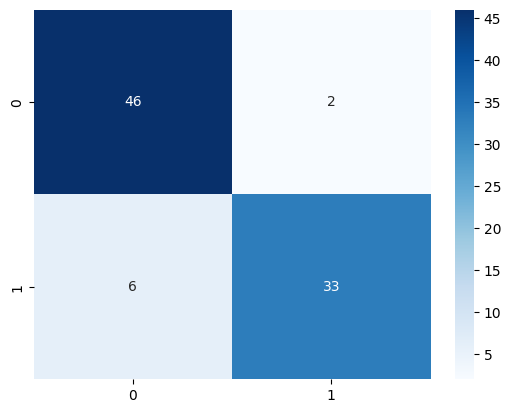

In [ ]:
cm = confusion_matrix(y_test, best_rf.predict(X_test_s))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.show()


In [ ]:
Xr_train, Xr_test, yr_train, yr_test = train_test_split(
    X, y_reg, test_size=0.2, random_state=42
)

yr_train = yr_train.fillna(yr_train.median())
yr_test = yr_test.fillna(yr_test.median())

rf_reg = RandomForestRegressor(random_state=42)
rf_reg.fit(Xr_train, yr_train)
pred = rf_reg.predict(Xr_test)

print("MAE:", mean_absolute_error(yr_test, pred))
print("RMSE:", np.sqrt(mean_squared_error(yr_test, pred)))
print("R²:", r2_score(yr_test, pred))


MAE: 0.15183908045977013
RMSE: 0.41103597739449005
R²: 0.9980160250900617


In [ ]:
# دمج X و y_reg معًا
reg_data = pd.concat([X, y_reg], axis=1)

# حذف الصفوف التي فيها NaN في Days_Difference فقط
reg_data = reg_data.dropna(subset=['Days_Difference'])

# فصل X و y_reg من جديد
X_reg = reg_data.drop(columns=['Days_Difference'])
y_reg_clean = reg_data['Days_Difference']

print("✅ Regression data shape:", X_reg.shape)



✅ Regression data shape: (397, 23)


In [ ]:
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(
    X_reg,
    y_reg_clean,
    test_size=0.2,
    random_state=42
)


In [ ]:
scaler_r = StandardScaler()

X_train_r_s = scaler_r.fit_transform(X_train_r)
X_test_r_s = scaler_r.transform(X_test_r)


In [ ]:
Xc_train, Xc_test, yc_train, yc_test = train_test_split(
    X, y_class,
    test_size=0.2,
    random_state=42,
    stratify=y_class
)

scaler_c = StandardScaler()
Xc_train_s = scaler_c.fit_transform(Xc_train)
Xc_test_s  = scaler_c.transform(Xc_test)

print("✅ Classification data ready")

✅ Classification data ready


In [ ]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# إزالة الصفوف التي فيها NaN في الهدف
reg_df = X.copy()
reg_df['target'] = y_reg

reg_df = reg_df.dropna(subset=['target'])

X_reg = reg_df.drop(columns=['target'])
y_reg_clean = reg_df['target']

Xr_train, Xr_test, yr_train, yr_test = train_test_split(
    X_reg,
    y_reg_clean,
    test_size=0.2,
    random_state=42
)

scaler_r = StandardScaler()
Xr_train_s = scaler_r.fit_transform(Xr_train)
Xr_test_s  = scaler_r.transform(Xr_test)

print("✅ Regression data ready")




✅ Regression data ready


In [ ]:
reg_models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(),
    "Gradient Boosting": GradientBoostingRegressor()
}

for name, model in reg_models.items():
    model.fit(Xr_train_s, yr_train)
    pred = model.predict(Xr_test_s)

    rmse = np.sqrt(mean_squared_error(yr_test, pred))

    print(f"\n{name}")
    print("MAE:", mean_absolute_error(yr_test, pred))
    print("RMSE:", rmse)
    print("R²:", r2_score(yr_test, pred))



Linear Regression
MAE: 0.07167467624560389
RMSE: 0.1198958712477126
R²: 0.9998420316629401

Decision Tree
MAE: 0.2375
RMSE: 0.8139410298049853
R²: 0.9927197302179274

Random Forest
MAE: 0.15487499999999998
RMSE: 0.44243502347802416
R²: 0.9978489000611268

Gradient Boosting
MAE: 0.06945705933993687
RMSE: 0.275678630235034
R²: 0.9991648436358133


In [ ]:
import shap
import matplotlib.pyplot as plt


In [ ]:
# أخذ عينة صغيرة للسرعة
sample_size = min(100, Xc_test_s.shape[0])
X_shap = Xc_test_s[:sample_size]

explainer = shap.TreeExplainer(best_rf)
shap_values = explainer.shap_values(X_shap)

print("✅ SHAP values calculated")


✅ SHAP values calculated


In [ ]:
# نستخدم بيانات بدون Scaling
X_shap = Xc_test.sample(
    n=min(100, Xc_test.shape[0]),
    random_state=42
)

print(X_shap.shape)

(87, 23)


In [ ]:
explainer = shap.Explainer(best_rf, Xc_train)
shap_values = explainer(X_shap)

print("✅ SHAP values generated correctly")


✅ SHAP values generated correctly


<Figure size 1000x600 with 0 Axes>

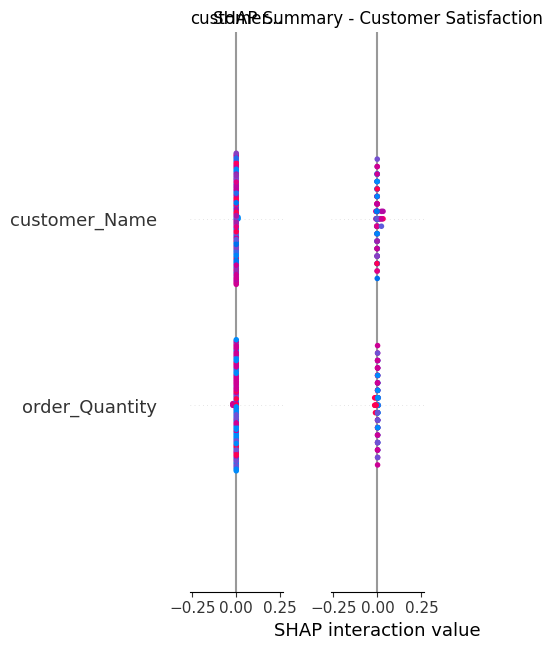

In [ ]:
plt.figure(figsize=(10, 6))
shap.summary_plot(
    shap_values,
    X_shap,
    show=False
)
plt.title("SHAP Summary - Customer Satisfaction")
plt.tight_layout()
plt.show()


<Figure size 800x600 with 0 Axes>

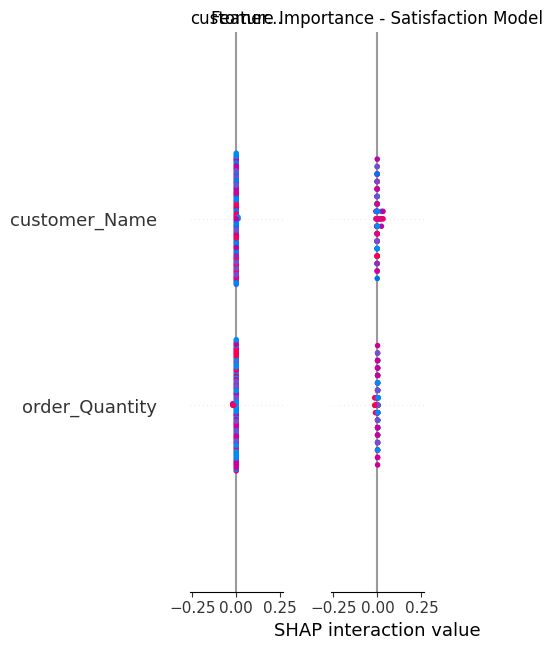

In [ ]:
plt.figure(figsize=(8, 6))
shap.summary_plot(
    shap_values,
    X_shap,
    plot_type="bar",
    show=False
)
plt.title("Feature Importance - Satisfaction Model")
plt.tight_layout()
plt.show()

In [ ]:
# أخذ عينة للتفسير
Xr_shap = Xr_test.sample(
    n=min(100, Xr_test.shape[0]),
    random_state=42
)

print("SHAP sample shape:", Xr_shap.shape)


SHAP sample shape: (80, 23)


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

param_grid_reg = {
    "n_estimators": [100, 200],
    "max_depth": [None, 20],
    "min_samples_split": [2, 5]
}

rf_reg = RandomForestRegressor(random_state=42)

grid_reg = GridSearchCV(
    rf_reg,
    param_grid_reg,
    cv=5,
    scoring="r2",
    n_jobs=-1
)

grid_reg.fit(Xr_train, y_train_r)

best_rf_reg = grid_reg.best_estimator_

print("✅ Best RF Regressor Params:", grid_reg.best_params_)
print("R² on test:",
      r2_score(y_test_r, best_rf_reg.predict(Xr_test)))



✅ Best RF Regressor Params: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
R² on test: 0.9981847128070934


In [ ]:
print("=" * 50)
print("🔧 Hyperparameter Tuning for Random Forest...")
print("This may take a few minutes...")

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

rf_tuned = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(
    rf_tuned,
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_s, y_train)

best_rf = grid_search.best_estimator_
best_rf_pred = best_rf.predict(X_test_s)
best_rf_acc = accuracy_score(y_test, best_rf_pred)

results['Random Forest (Tuned)'] = best_rf_acc

print(f"\n✅ Best Parameters: {grid_search.best_params_}")
print(f"✅ Best Accuracy: {best_rf_acc:.4f}")


🔧 Hyperparameter Tuning for Random Forest...
This may take a few minutes...
Fitting 5 folds for each of 24 candidates, totalling 120 fits

✅ Best Parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
✅ Best Accuracy: 0.9195


In [ ]:
sat_results_df = pd.DataFrame({
    'Model': results.keys(),
    'Accuracy': results.values()
}).sort_values('Accuracy', ascending=False)

sat_results_df['Accuracy (%)'] = (sat_results_df['Accuracy'] * 100).round(2)
sat_results_df['Model Type'] = sat_results_df['Model'].apply(
    lambda x: 'Ensemble' if x in [
        'Random Forest', 'Gradient Boosting', 'AdaBoost', 'Random Forest (Tuned)'
    ] else 'Non-Ensemble'
)

print(sat_results_df)


                   Model  Accuracy  Accuracy (%)    Model Type
5      Gradient Boosting  0.942529         94.25      Ensemble
1          Decision Tree  0.919540         91.95  Non-Ensemble
4          Random Forest  0.919540         91.95      Ensemble
6               AdaBoost  0.919540         91.95      Ensemble
7  Random Forest (Tuned)  0.919540         91.95      Ensemble
3                    SVM  0.724138         72.41  Non-Ensemble
2                    KNN  0.701149         70.11  Non-Ensemble
0    Logistic Regression  0.609195         60.92  Non-Ensemble


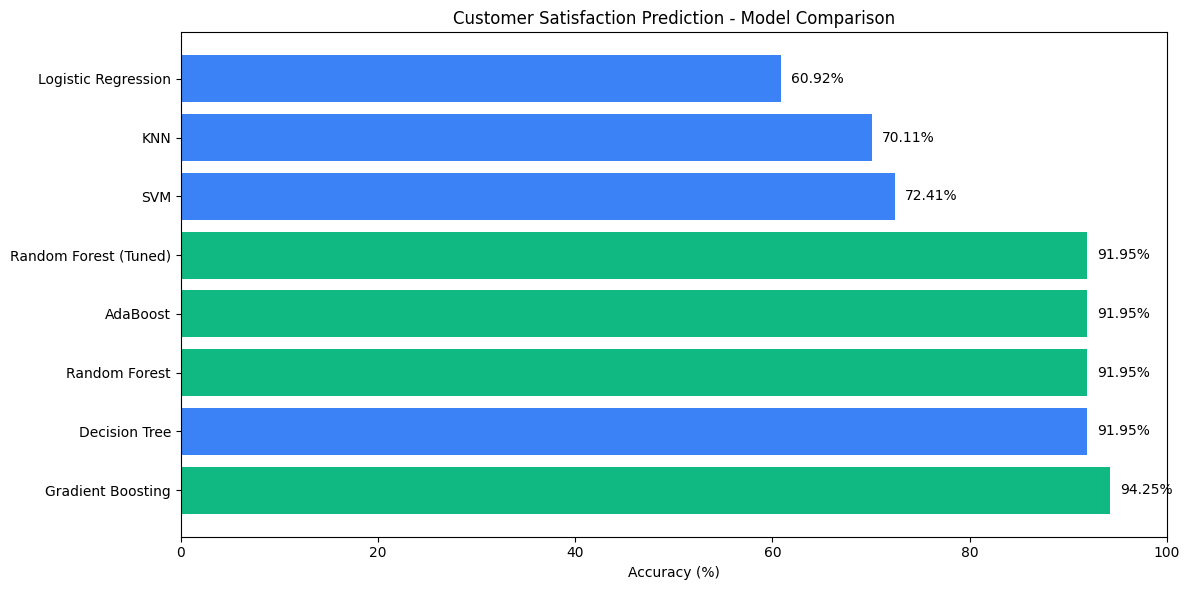

In [ ]:
plt.figure(figsize=(12, 6))
colors = ['#10b981' if t == 'Ensemble' else '#3b82f6'
          for t in sat_results_df['Model Type']]

bars = plt.barh(
    sat_results_df['Model'],
    sat_results_df['Accuracy (%)'],
    color=colors
)

plt.xlabel('Accuracy (%)')
plt.title('Customer Satisfaction Prediction - Model Comparison')
plt.xlim(0, 100)

for bar, acc in zip(bars, sat_results_df['Accuracy (%)']):
    plt.text(bar.get_width() + 1,
             bar.get_y() + bar.get_height()/2,
             f'{acc:.2f}%',
             va='center')

plt.tight_layout()
plt.savefig('satisfaction_model_comparison.png', dpi=150)
plt.show()


               precision    recall  f1-score   support

Not Satisfied       0.96      0.90      0.92        48
    Satisfied       0.88      0.95      0.91        39

     accuracy                           0.92        87
    macro avg       0.92      0.92      0.92        87
 weighted avg       0.92      0.92      0.92        87



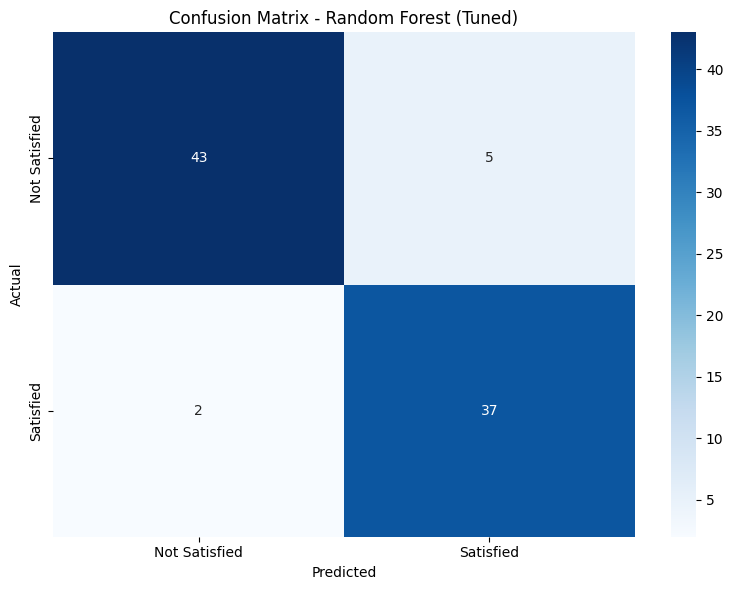

In [ ]:
print(classification_report(
    y_test,
    best_rf_pred,
    target_names=['Not Satisfied', 'Satisfied']
))

cm = confusion_matrix(y_test, best_rf_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm, annot=True, fmt='d', cmap='Blues',
    xticklabels=['Not Satisfied', 'Satisfied'],
    yticklabels=['Not Satisfied', 'Satisfied']
)
plt.title('Confusion Matrix - Random Forest (Tuned)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.savefig('satisfaction_confusion_matrix.png', dpi=150)
plt.show()


In [ ]:
# ================================
# Define Feature Columns (REQUIRED)
# ================================

exclude_cols = [
    'Satisfaction',
    'Total_Amount',
    'Days_Difference',
    'delivery_date',
    'promised_date',
    'order_date',
    'customer_id',
    'order_id'
]

feature_cols = [col for col in data.columns if col not in exclude_cols]

print("✅ feature_cols defined successfully")
print("Number of features:", len(feature_cols))
print(feature_cols)


✅ feature_cols defined successfully
Number of features: 23
['order_Quantity', 'customer_Name', 'Actual_Delivery_Days', 'order_Tailor', 'order_Type', 'order_Tax', 'order_Discount', 'delivery_Type', 'delivery_Order_Ref', 'order_Delivered_Quantity', 'delivery_Quantity', 'Month', 'order_Tailor_Name', 'Expected_Delivery_Days', 'Tailoring_Style', 'size', 'length_cm', 'width_cm', 'sleeve_cm', 'fabric_meters', 'Price_Per_Unit', 'Fabric_Price_Per_Meter', 'Dissatisfaction_Reason']


In [ ]:
target_price = 'Total_Amount'

X_price = data[feature_cols].copy()
y_price = data[target_price].copy()

X_price = X_price.fillna(X_price.median())
y_price = y_price.fillna(y_price.median())

X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(
    X_price, y_price, test_size=0.2, random_state=42
)

scaler_p = StandardScaler()
X_train_p_s = scaler_p.fit_transform(X_train_p)
X_test_p_s = scaler_p.transform(X_test_p)


In [ ]:
price_results = {}

models_reg = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42)
}

for name, model in models_reg.items():
    model.fit(X_train_p_s, y_train_p)
    pred = model.predict(X_test_p_s)
    r2 = r2_score(y_test_p, pred)
    price_results[name] = r2
    print(f"{name} R²: {r2:.4f}")


Linear Regression R²: 1.0000
Decision Tree R²: 0.9991
Random Forest R²: 0.9990
Gradient Boosting R²: 0.9998


In [ ]:
price_results_df = pd.DataFrame({
    'Model': price_results.keys(),
    'R² Score': price_results.values()
}).sort_values('R² Score', ascending=False)

price_results_df['R² (%)'] = (price_results_df['R² Score'] * 100).round(2)
price_results_df


,Model,R² Score,R² (%)
0,Linear Regression,1.000000,100.00
3,Gradient Boosting,0.999762,99.98
1,Decision Tree,0.999125,99.91
2,Random Forest,0.999024,99.90


from matplotlib import pyplot as plt
price_results_df['R² Score'].plot(kind='hist', bins=20, title='R² Score')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
price_results_df['R² (%)'].plot(kind='hist', bins=20, title='R² (%)')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
price_results_df.groupby('Model').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
price_results_df.plot(kind='scatter', x='R² Score', y='R² (%)', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
price_results_df['R² Score'].plot(kind='line', figsize=(8, 4), title='R² Score')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
price_results_df['R² (%)'].plot(kind='line', figsize=(8, 4), title='R² (%)')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(price_results_df['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(price_results_df, x='R² Score', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(price_results_df['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(price_results_df, x='R² (%)', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

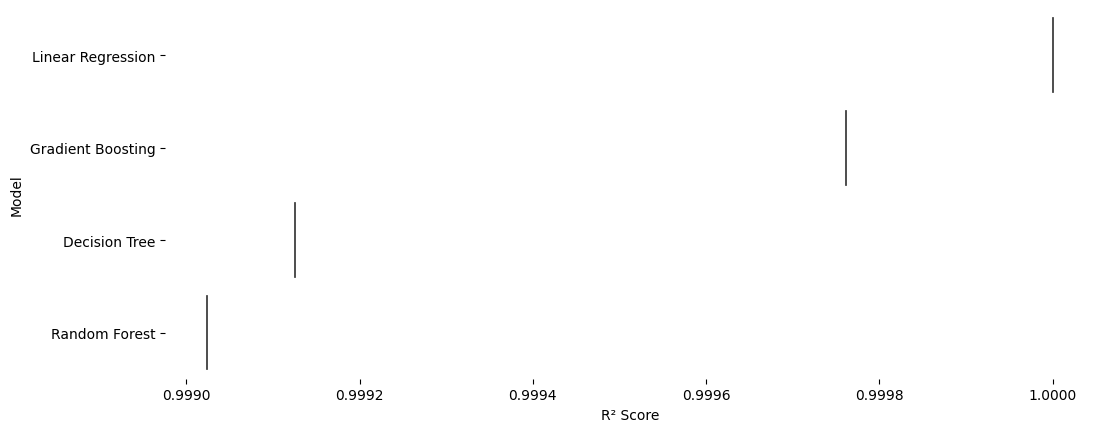

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(price_results_df['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(price_results_df, x='R² Score', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

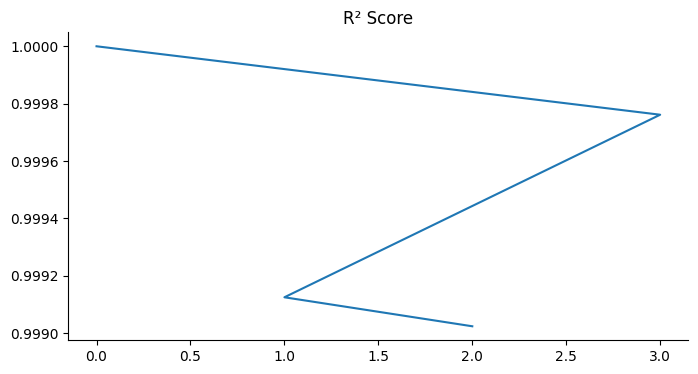

In [ ]:
from matplotlib import pyplot as plt
price_results_df['R² Score'].plot(kind='line', figsize=(8, 4), title='R² Score')
plt.gca().spines[['top', 'right']].set_visible(False)

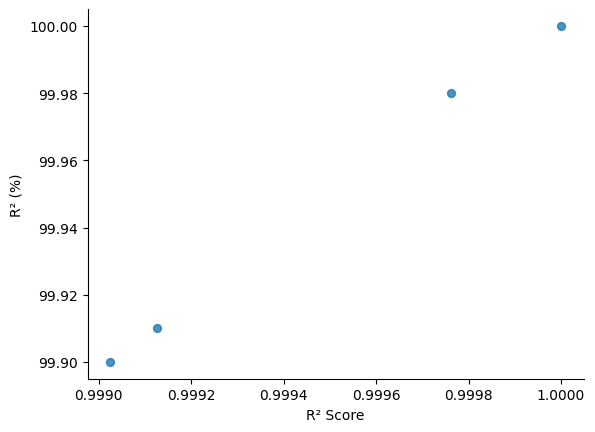

In [ ]:
from matplotlib import pyplot as plt
price_results_df.plot(kind='scatter', x='R² Score', y='R² (%)', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

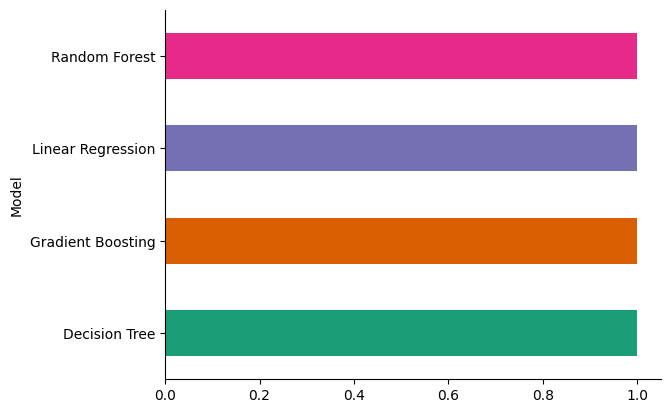

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
price_results_df.groupby('Model').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

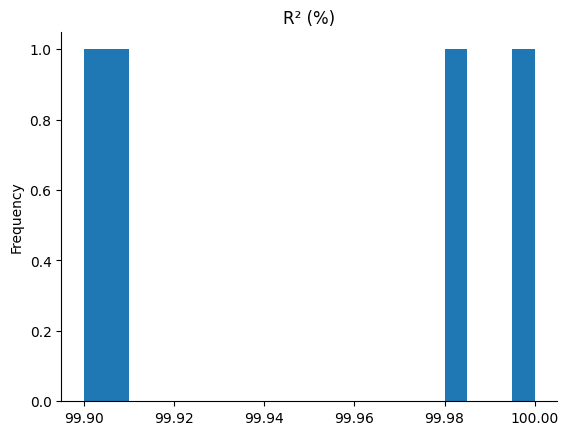

In [ ]:
from matplotlib import pyplot as plt
price_results_df['R² (%)'].plot(kind='hist', bins=20, title='R² (%)')
plt.gca().spines[['top', 'right',]].set_visible(False)

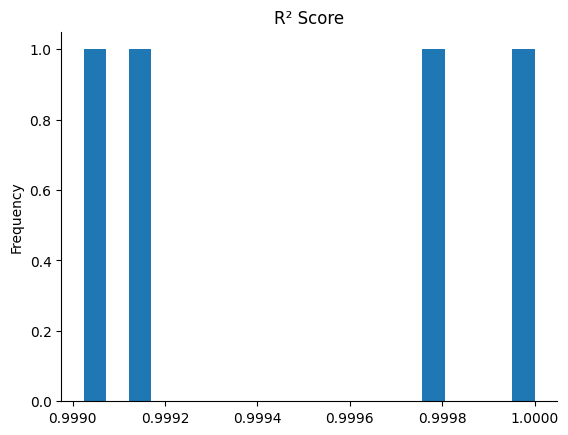

In [ ]:
from matplotlib import pyplot as plt
price_results_df['R² Score'].plot(kind='hist', bins=20, title='R² Score')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
# ====================================
# Prepare Data for Satisfaction (FINAL)
# ====================================

# Features & Target
X_sat = data[feature_cols].copy()
y_sat = data['Satisfaction'].copy()

# Handle missing values
X_sat = X_sat.fillna(X_sat.median())

# Train / Test Split
from sklearn.model_selection import train_test_split
X_train_sat, X_test_sat, y_train_sat, y_test_sat = train_test_split(
    X_sat,
    y_sat,
    test_size=0.2,
    random_state=42,
    stratify=y_sat
)

# Scaling (IMPORTANT for SHAP consistency)
from sklearn.preprocessing import StandardScaler
scaler_sat = StandardScaler()
X_train_sat_scaled = scaler_sat.fit_transform(X_train_sat)
X_test_sat_scaled = scaler_sat.transform(X_test_sat)

print("✅ X_train_sat_scaled is ready")
print("Train shape:", X_train_sat_scaled.shape)
print("Test shape:", X_test_sat_scaled.shape)


✅ X_train_sat_scaled is ready
Train shape: (348, 23)
Test shape: (87, 23)


In [ ]:
# ====================================
# SHAP Analysis - FINAL (Safe Version)
# ====================================

print("=" * 60)
print("🔬 SHAP ANALYSIS - Customer Satisfaction")
print("=" * 60)

# Use EXACT training format
X_shap = X_train_sat_scaled
feature_names = feature_cols

# Reduce size for speed
sample_size = min(100, X_shap.shape[0])
X_shap_sample = X_shap[:sample_size]

# SHAP Explainer
explainer_sat = shap.TreeExplainer(best_rf)
shap_values_sat = explainer_sat.shap_values(X_shap_sample)

print("✅ SHAP values generated successfully")


🔬 SHAP ANALYSIS - Customer Satisfaction
✅ SHAP values generated successfully


In [ ]:
# ====================================
# FIX: Rebuild SHAP input correctly
# ====================================

# عدد العينات
sample_size = min(100, X_train_sat_scaled.shape[0])

# إعادة تحويل NumPy array إلى DataFrame بنفس الأعمدة
X_shap_df = pd.DataFrame(
    X_train_sat_scaled[:sample_size],
    columns=feature_cols
)

print("X_shap_df shape:", X_shap_df.shape)
print("Features:", len(feature_cols))



X_shap_df shape: (100, 23)
Features: 23


In [ ]:
# =========================================================
# Train a SHAP-compatible Random Forest (NO SCALING)
# =========================================================

rf_shap = RandomForestClassifier(
    n_estimators=100,
    random_state=42
)

rf_shap.fit(X_train_sat, y_train_sat)

print("✅ SHAP-compatible Random Forest trained")



✅ SHAP-compatible Random Forest trained


In [ ]:
# =========================================================
# Prepare SHAP input (RAW features, same as training)
# =========================================================

sample_size = min(100, X_train_sat.shape[0])

X_shap = X_train_sat.iloc[:sample_size]

print("X_shap shape:", X_shap.shape)
print("Feature count:", X_shap.shape[1])


X_shap shape: (100, 23)
Feature count: 23


In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_shap = RandomForestClassifier(
    n_estimators=100,
    random_state=42
)

rf_shap.fit(X_train_sat, y_train_sat)

print("✅ Random Forest trained for SHAP (raw features)")



✅ Random Forest trained for SHAP (raw features)


In [ ]:
import shap

# نمرر الموديل + البيانات الخام
explainer = shap.Explainer(rf_shap, X_train_sat)

print("✅ SHAP Explainer created (new API)")


✅ SHAP Explainer created (new API)


In [ ]:
# نأخذ عينة فقط
sample_size = min(100, X_train_sat.shape[0])
X_shap = X_train_sat.iloc[:sample_size]

shap_values = explainer(X_shap)

print("✅ SHAP values computed")
print("SHAP values shape:", shap_values.values.shape)
print("X_shap shape:", X_shap.shape)


✅ SHAP values computed
SHAP values shape: (100, 23, 2)
X_shap shape: (100, 23)


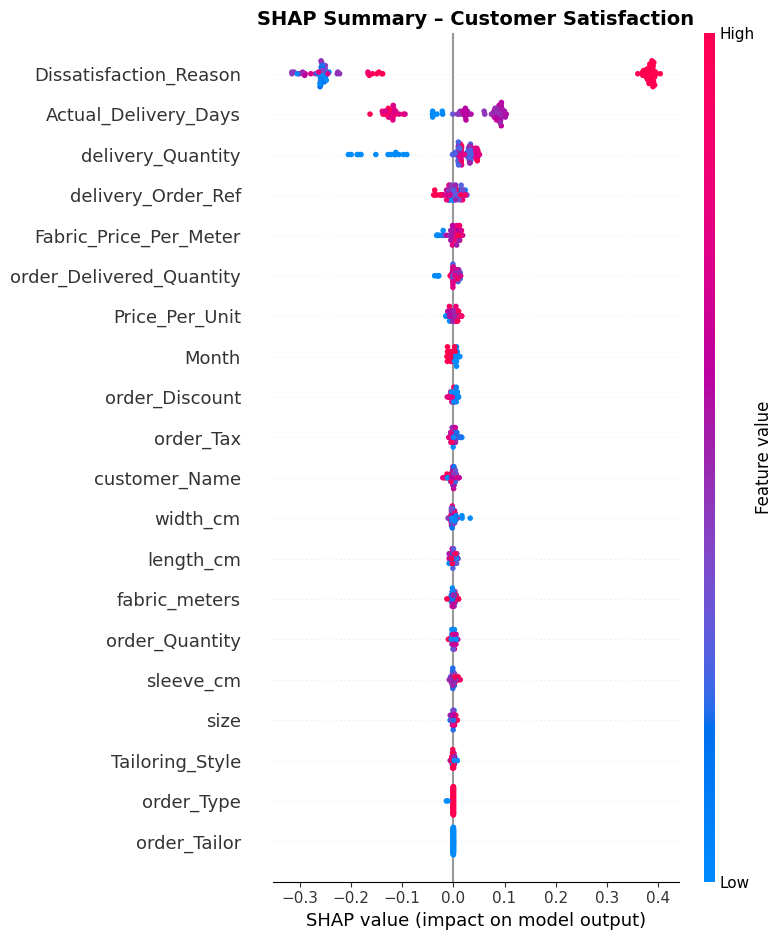

✅ SHAP Summary plot generated successfully


In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
shap.summary_plot(
    shap_values.values[:, :, 1],  # class = Satisfied
    X_shap,
    feature_names=X_shap.columns,
    show=False
)

plt.title("SHAP Summary – Customer Satisfaction", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.savefig("shap_satisfaction_summary.png", dpi=150)
plt.show()

print("✅ SHAP Summary plot generated successfully")


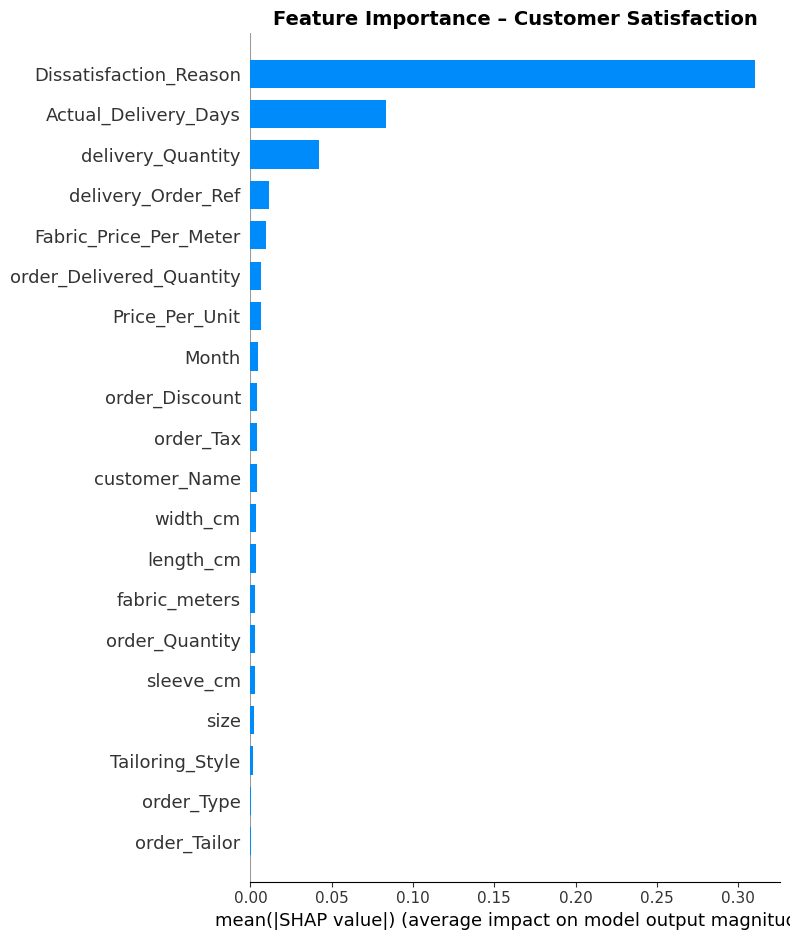

✅ SHAP Bar plot generated successfully


In [ ]:
plt.figure(figsize=(10, 6))
shap.summary_plot(
    shap_values.values[:, :, 1],
    X_shap,
    plot_type="bar",
    show=False
)

plt.title("Feature Importance – Customer Satisfaction", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.savefig("shap_satisfaction_bar.png", dpi=150)
plt.show()

print("✅ SHAP Bar plot generated successfully")
